# **Import librares**

In [37]:
!pip install Keras-Preprocessing
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import pickle
import joblib
from collections import Counter
from textblob import Word
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, f1_score, recall_score
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential, load_model
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras_preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.layers import Activation, Dense, Embedding, LSTM, SpatialDropout1D, Dropout, Flatten, GRU, Conv1D, MaxPooling1D, Bidirectional
from PIL import Image
import urllib
import requests
from keras.regularizers import l2
!pip install ktrain
import ktrain
from ktrain import text
sns.set()
%matplotlib inline

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [38]:
df=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/NLP/Suicide_Ideation_Dataset(Twitter-based).csv", engine='python', encoding='UTF-8')
df=df.replace('Potential Suicide post ','Potential Suicide post')
df['Suicide'].value_counts()
df

,Tweet,Suicide
0,making some lunch,Not Suicide post
1,@Alexia You want his money.,Not Suicide post
2,@dizzyhrvy that crap took me forever to put to...,Potential Suicide post
3,@jnaylor #kiwitweets Hey Jer! Since when did y...,Not Suicide post
4,Trying out &quot;Delicious Library 2&quot; wit...,Not Suicide post
...,...,...
1782,i have forgotten how much i love my Nokia N95-1,Not Suicide post
1783,Starting my day out with a positive attitude! ...,Not Suicide post
1784,"@belledame222 Hey, it's 5 am...give a girl som...",Not Suicide post
1785,2 drunken besties stumble into my room and we ...,Not Suicide post


In [39]:
df['Tweet']=df['Tweet'].fillna("")
df.isna().sum()

Tweet      0
Suicide    0
dtype: int64

# **Deep Learning Models**

In [40]:
vocabulary_size =6000
max_text_len = 60
tokenizer = Tokenizer(num_words=vocabulary_size)
tokenizer.fit_on_texts(df['Tweet'].values)
le=len(tokenizer.word_index)+1
print(le)
sequences = tokenizer.texts_to_sequences(df['Tweet'].values)
X_DeepLearning = pad_sequences(sequences, maxlen=max_text_len)
X_DeepLearning.shape[1]

6573


60

In [41]:
# Save the tokenizer object
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [42]:
df.loc[df['Suicide'] == 'Potential Suicide post' , 'LABEL'] = 0
df.loc[df['Suicide'] == 'Not Suicide post', 'LABEL'] = 1

labels = to_categorical(df['LABEL'], num_classes=2)
print(labels[:])

[[0. 1.]
 [0. 1.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]


In [43]:
XX_train, XX_test, y_train, y_test = train_test_split(X_DeepLearning , labels, test_size=0.25, random_state=42)
print((XX_train.shape, y_train.shape, XX_test.shape, y_test.shape))

((1340, 60), (1340, 2), (447, 60), (447, 2))


# **LSTM 1-Layer**

In [44]:
epochs = 15
emb_dim = 120
batch_size = 50
model_lstm1 = Sequential()
model_lstm1.add(Embedding(vocabulary_size,emb_dim, input_length=X_DeepLearning.shape[1]))
model_lstm1.add(SpatialDropout1D(0.8))
model_lstm1.add(Bidirectional(LSTM(300, dropout=0.5, recurrent_dropout=0.5)))
model_lstm1.add(Dropout(0.5))
model_lstm1.add(Flatten())
model_lstm1.add(Dense(64, activation='relu'))
model_lstm1.add(Dropout(0.5))
model_lstm1.add(Dense(2, activation='softmax'))
model_lstm1.compile(optimizer=tf.optimizers.Adam(),loss='binary_crossentropy', metrics=['acc'])
print(model_lstm1.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 60, 120)           720000    
                                                                 
 spatial_dropout1d_4 (Spatia  (None, 60, 120)          0         
 lDropout1D)                                                     
                                                                 
 bidirectional_5 (Bidirectio  (None, 600)              1010400   
 nal)                                                            
                                                                 
 dropout_10 (Dropout)        (None, 600)               0         
                                                                 
 flatten_3 (Flatten)         (None, 600)               0         
                                                                 
 dense_8 (Dense)             (None, 64)               

In [45]:
checkpoint_callback = ModelCheckpoint(filepath="lastm-1-layer-best_model.h5", save_best_only=True, monitor="val_acc", mode="max", verbose=1)

early_stopping_callback = EarlyStopping(monitor="val_acc", mode="max", patience=10, verbose=1, restore_best_weights=True)

reduce_lr_callback = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, verbose=1, mode="min", min_delta=0.0001, cooldown=0, min_lr=0)

callbacks=[checkpoint_callback, early_stopping_callback, reduce_lr_callback]

In [46]:
history_lstm1 = model_lstm1.fit(XX_train, y_train, epochs = epochs, batch_size = batch_size, validation_data=(XX_test,y_test), callbacks=callbacks)

Epoch 1/15
27/27 [==============================] - ETA: 0s - loss: 0.6463 - acc: 0.6321
Epoch 1: val_acc improved from -inf to 0.73602, saving model to lastm-1-layer-best_model.h5
27/27 [==============================] - 79s 3s/step - loss: 0.6463 - acc: 0.6321 - val_loss: 0.6405 - val_acc: 0.7360 - lr: 0.0010
Epoch 2/15
27/27 [==============================] - ETA: 0s - loss: 0.5492 - acc: 0.7478
Epoch 2: val_acc improved from 0.73602 to 0.80537, saving model to lastm-1-layer-best_model.h5
27/27 [==============================] - 48s 2s/step - loss: 0.5492 - acc: 0.7478 - val_loss: 0.4397 - val_acc: 0.8054 - lr: 0.0010
Epoch 3/15
27/27 [==============================] - ETA: 0s - loss: 0.3866 - acc: 0.8425
Epoch 3: val_acc improved from 0.80537 to 0.87025, saving model to lastm-1-layer-best_model.h5
27/27 [==============================] - 50s 2s/step - loss: 0.3866 - acc: 0.8425 - val_loss: 0.3194 - val_acc: 0.8702 - lr: 0.0010
Epoch 4/15
27/27 [==============================] - ETA

In [47]:
results_1 = model_lstm1.evaluate(XX_test, y_test, verbose=False)
print(f'Test results - Loss: {results_1[0]} - Accuracy: {100*results_1[1]}%')

Test results - Loss: 0.17475254833698273 - Accuracy: 92.84116625785828%


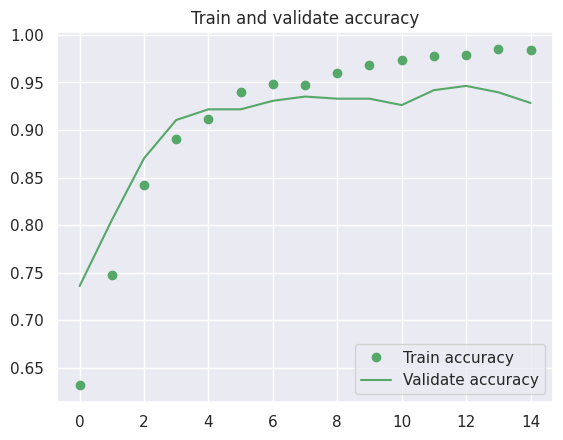

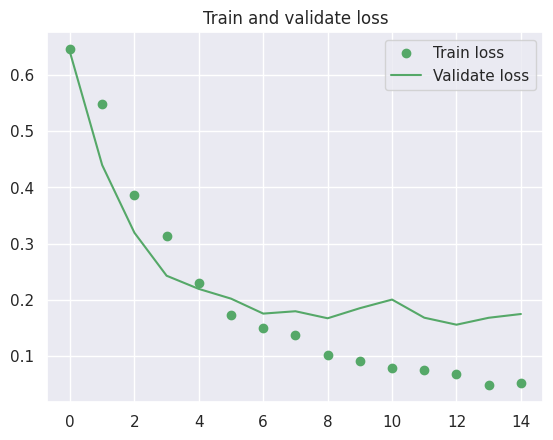

In [48]:
acc = history_lstm1.history['acc']
val_acc = history_lstm1.history['val_acc']
loss = history_lstm1.history['loss']
val_loss = history_lstm1.history['val_loss']
plt.plot( acc, 'go', label='Train accuracy')
plt.plot( val_acc, 'g', label='Validate accuracy')
plt.title('Train and validate accuracy')
plt.legend()

plt.figure()
plt.plot( loss, 'go', label='Train loss')
plt.plot( val_loss, 'g', label='Validate loss')
plt.title('Train and validate loss')
plt.legend()
plt.show()

In [49]:
# Load tokenizer object
with open('/content/tokenizer.pickle', 'rb') as handle:
    tokenizers = pickle.load(handle)

model = load_model('/content/lastm-1-layer-best_model.h5')

In [50]:
twt = ['I want to run infront of a running car and die.']
twt = tokenizers.texts_to_sequences(twt)
twt = pad_sequences(twt, maxlen=60, dtype='int32')

predicted = model.predict(twt,batch_size=1,verbose = True)
if(np.argmax(predicted) == 0):
    print("Potential Suicide Post")
elif (np.argmax(predicted) == 1):
    print("Non Suicide Post")

1/1 [==============================] - 1s 611ms/step
Potential Suicide Post


## **LSTM 2-Layers**

In [51]:
epochs = 15
emb_dim = 120
batch_size = 50
model_lstm2 = Sequential()
model_lstm2.add(Embedding(vocabulary_size,emb_dim ,input_length=X_DeepLearning.shape[1]))
model_lstm2.add(SpatialDropout1D(0.8))
model_lstm2.add(Bidirectional(LSTM(200, dropout=0.5, recurrent_dropout=0.5, return_sequences= True)))
model_lstm2.add(Dropout(0.5))
model_lstm2.add(Bidirectional(LSTM(300, dropout=0.5, recurrent_dropout =0.5)))
model_lstm2.add(Dropout(0.5))
model_lstm2.add(Flatten())
model_lstm2.add(Dense(64, activation='relu'))
model_lstm2.add(Dropout(0.5))
model_lstm2.add(Dense(2, activation='softmax'))
model_lstm2.compile(optimizer=tf.optimizers.Adam(),loss='binary_crossentropy', metrics=['acc'])
print(model_lstm2.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 60, 120)           720000    
                                                                 
 spatial_dropout1d_5 (Spatia  (None, 60, 120)          0         
 lDropout1D)                                                     
                                                                 
 bidirectional_6 (Bidirectio  (None, 60, 400)          513600    
 nal)                                                            
                                                                 
 dropout_12 (Dropout)        (None, 60, 400)           0         
                                                                 
 bidirectional_7 (Bidirectio  (None, 600)              1682400   
 nal)                                                            
                                                      

In [52]:
checkpoint_callback = ModelCheckpoint(filepath="lastm-2-layer-best_model.h5", save_best_only=True, monitor="val_acc", mode="max", verbose=1)

early_stopping_callback = EarlyStopping(monitor="val_acc", mode="max", patience=10, verbose=1, restore_best_weights=True)

reduce_lr_callback = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, verbose=1, mode="min", min_delta=0.0001, cooldown=0, min_lr=0)

callbacks2=[checkpoint_callback, early_stopping_callback, reduce_lr_callback]

In [53]:
history_lstm2 = model_lstm2.fit(XX_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(XX_test,y_test), callbacks=callbacks2)

Epoch 1/15
27/27 [==============================] - ETA: 0s - loss: 0.6616 - acc: 0.6478
Epoch 1: val_acc improved from -inf to 0.68680, saving model to lastm-2-layer-best_model.h5
27/27 [==============================] - 138s 4s/step - loss: 0.6616 - acc: 0.6478 - val_loss: 0.5856 - val_acc: 0.6868 - lr: 0.0010
Epoch 2/15
27/27 [==============================] - ETA: 0s - loss: 0.5069 - acc: 0.7724
Epoch 2: val_acc improved from 0.68680 to 0.85682, saving model to lastm-2-layer-best_model.h5
27/27 [==============================] - 98s 4s/step - loss: 0.5069 - acc: 0.7724 - val_loss: 0.3621 - val_acc: 0.8568 - lr: 0.0010
Epoch 3/15
27/27 [==============================] - ETA: 0s - loss: 0.3936 - acc: 0.8604
Epoch 3: val_acc improved from 0.85682 to 0.88143, saving model to lastm-2-layer-best_model.h5
27/27 [==============================] - 97s 4s/step - loss: 0.3936 - acc: 0.8604 - val_loss: 0.2896 - val_acc: 0.8814 - lr: 0.0010
Epoch 4/15
27/27 [==============================] - ET

In [54]:
results_2 = model_lstm2.evaluate(XX_test, y_test, verbose=False)
print(f'Test results - Loss: {results_2[0]} - Accuracy: {100*results_2[1]}%')

Test results - Loss: 0.1714377999305725 - Accuracy: 93.28858852386475%


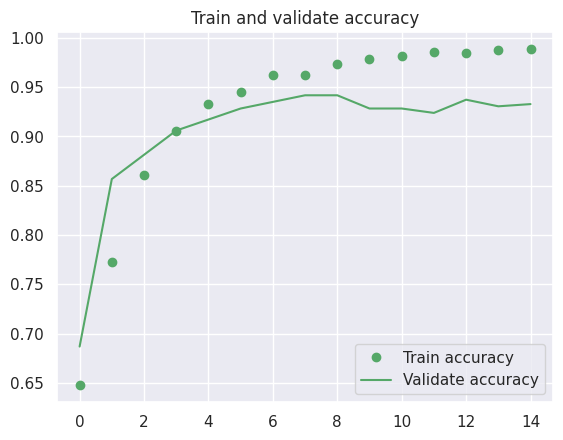

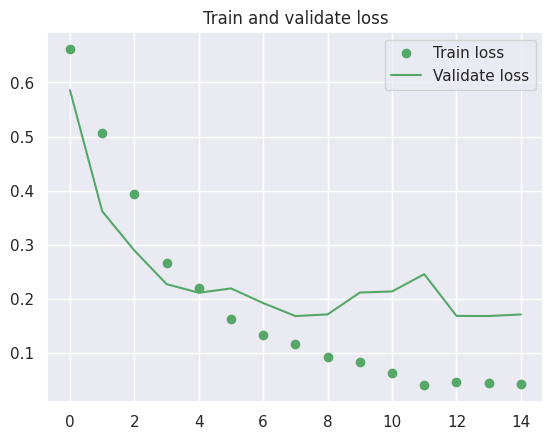

In [55]:
acc = history_lstm2.history['acc']
val_acc = history_lstm2.history['val_acc']
loss = history_lstm2.history['loss']
val_loss = history_lstm2.history['val_loss']

plt.plot( acc, 'go', label='Train accuracy')
plt.plot( val_acc, 'g', label='Validate accuracy')
plt.title('Train and validate accuracy')
plt.legend()

plt.figure()

plt.plot( loss, 'go', label='Train loss')
plt.plot( val_loss, 'g', label='Validate loss')
plt.title('Train and validate loss')
plt.legend()

plt.show()

In [56]:
# Load tokenizer object
with open('/content/tokenizer.pickle', 'rb') as handle:
    tokenizers = pickle.load(handle)

model = load_model('/content/lastm-2-layer-best_model.h5')

In [57]:
twt = ["This is too much for me, I can't take it anymore, I will die." ]
twt = tokenizers.texts_to_sequences(twt)
twt = pad_sequences(twt, maxlen=60, dtype='int32')

predicted = model.predict(twt,batch_size=1,verbose = True)
if(np.argmax(predicted) == 0):
    print("Potential Suicide Post")
elif (np.argmax(predicted) == 1):
    print("Non Suicide Post")

1/1 [==============================] - 1s 1s/step
Potential Suicide Post


## **GRU**

In [58]:
epochs = 15
emb_dim = 120
batch_size = 50
model_gru = Sequential()
model_gru.add(Embedding(vocabulary_size,emb_dim ,input_length=X_DeepLearning.shape[1]))
model_gru.add(SpatialDropout1D(0.8))
model_gru.add(GRU(units=16,  dropout=0.2, recurrent_dropout=0.2, kernel_regularizer=l2(0.01)))
model_gru.add(Dropout(0.5))
model_gru.add(Dense(228, activation='relu', kernel_regularizer=l2(0.01)))
model_gru.add(Dropout(0.5))
model_gru.add(Dense(2, activation='softmax'))
model_gru.compile(optimizer=tf.optimizers.Adam(),loss='binary_crossentropy', metrics=['acc'])
print(model_gru.summary())

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 60, 120)           720000    
                                                                 
 spatial_dropout1d_6 (Spatia  (None, 60, 120)          0         
 lDropout1D)                                                     
                                                                 
 gru_1 (GRU)                 (None, 16)                6624      
                                                                 
 dropout_15 (Dropout)        (None, 16)                0         
                                                                 
 dense_12 (Dense)            (None, 228)               3876      
                                                                 
 dropout_16 (Dropout)        (None, 228)               0         
                                                      

In [59]:
checkpoint_callback = ModelCheckpoint(filepath="gru-best_model.h5", save_best_only=True, monitor="val_acc", mode="max", verbose=1)

early_stopping_callback = EarlyStopping(monitor="val_acc", mode="max", patience=10, verbose=1, restore_best_weights=True)

reduce_lr_callback = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, verbose=1, mode="min", min_delta=0.0001, cooldown=0, min_lr=0)

callbacks3=[checkpoint_callback, early_stopping_callback, reduce_lr_callback]

In [60]:
history_gru = model_gru.fit(XX_train, y_train, epochs=epochs, batch_size=batch_size,validation_data=(XX_test,y_test), callbacks=callbacks3)

Epoch 1/15
27/27 [==============================] - ETA: 0s - loss: 1.4809 - acc: 0.6097
Epoch 1: val_acc improved from -inf to 0.61745, saving model to gru-best_model.h5
27/27 [==============================] - 10s 192ms/step - loss: 1.4809 - acc: 0.6097 - val_loss: 1.2896 - val_acc: 0.6174 - lr: 0.0010
Epoch 2/15
27/27 [==============================] - ETA: 0s - loss: 1.1504 - acc: 0.6351
Epoch 2: val_acc did not improve from 0.61745
27/27 [==============================] - 3s 113ms/step - loss: 1.1504 - acc: 0.6351 - val_loss: 1.0294 - val_acc: 0.6174 - lr: 0.0010
Epoch 3/15
27/27 [==============================] - ETA: 0s - loss: 0.9331 - acc: 0.6351
Epoch 3: val_acc did not improve from 0.61745
27/27 [==============================] - 3s 95ms/step - loss: 0.9331 - acc: 0.6351 - val_loss: 0.8551 - val_acc: 0.6174 - lr: 0.0010
Epoch 4/15
27/27 [==============================] - ETA: 0s - loss: 0.7560 - acc: 0.6433
Epoch 4: val_acc improved from 0.61745 to 0.76957, saving model to g

In [61]:
results_3 = model_gru.evaluate(XX_test, y_test, verbose=False)
print(f'Test results - Loss: {results_3[0]} - Accuracy: {100*results_3[1]}%')

Test results - Loss: 0.24421939253807068 - Accuracy: 92.39373803138733%


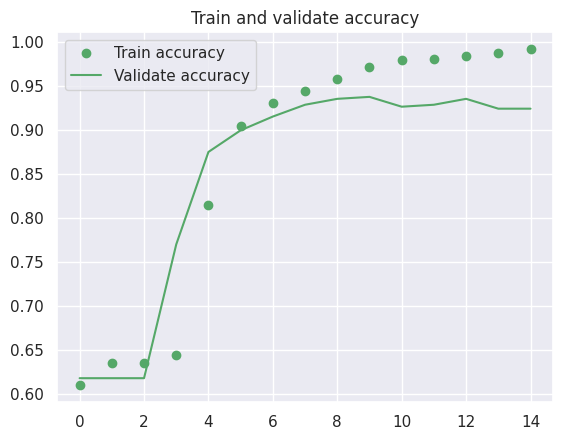

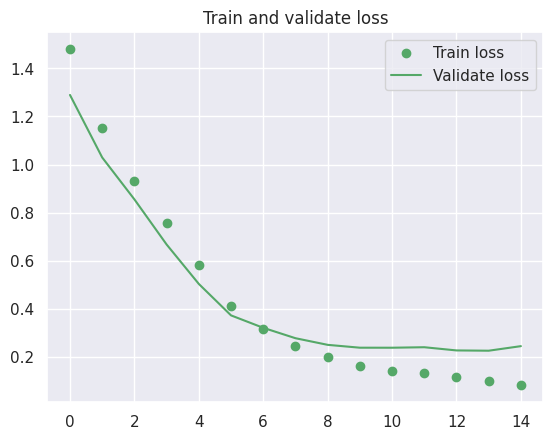

In [62]:
acc = history_gru.history['acc']
val_acc = history_gru.history['val_acc']
loss = history_gru.history['loss']
val_loss = history_gru.history['val_loss']

plt.plot( acc, 'go', label='Train accuracy')
plt.plot( val_acc, 'g', label='Validate accuracy')
plt.title('Train and validate accuracy')
plt.legend()

plt.figure()

plt.plot( loss, 'go', label='Train loss')
plt.plot( val_loss, 'g', label='Validate loss')
plt.title('Train and validate loss')
plt.legend()

plt.show()

In [63]:
# Load tokenizer object
with open('/content/tokenizer.pickle', 'rb') as handle:
    tokenizers = pickle.load(handle)

model = load_model('/content/gru-best_model.h5')

In [64]:
twt = ["I hate my life."]
twt = tokenizers.texts_to_sequences(twt)
twt = pad_sequences(twt, maxlen=60, dtype='int32')

predicted = model.predict(twt,batch_size=1,verbose = True)
if(np.argmax(predicted) == 0):
    print("Potential Suicide Post")
elif (np.argmax(predicted) == 1):
    print("Non Suicide Post")

1/1 [==============================] - 0s 328ms/step
Potential Suicide Post


## **CNN+LSTM**

In [65]:
epochs = 10
emb_dim = 120
batch_size = 50
model_cl = Sequential()
model_cl.add(Embedding(vocabulary_size,emb_dim, input_length=X_DeepLearning.shape[1]))
model_cl.add(SpatialDropout1D(0.8))
model_cl.add(Conv1D(filters=64, kernel_size=6, padding='same', activation='relu'))
model_cl.add(MaxPooling1D(pool_size=2))
model_cl.add(Conv1D(filters=32, kernel_size=6, activation='relu'))
model_cl.add(MaxPooling1D(pool_size=2))
model_cl.add(Bidirectional(LSTM(100, dropout=0.5, recurrent_dropout=0.5, return_sequences=True)))
model_cl.add(Dropout(0.5))
model_cl.add(Bidirectional(LSTM(400, dropout=0.5, recurrent_dropout=0.5)))
model_cl.add(Dropout(0.5))
model_cl.add(Flatten())
model_cl.add(Dense(64, activation='relu'))
model_cl.add(Dropout(0.5))
model_cl.add(Dense(2, activation='softmax'))
model_cl.compile(optimizer='adam',loss='binary_crossentropy', metrics=['acc'])
print(model_cl.summary())

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 60, 120)           720000    
                                                                 
 spatial_dropout1d_7 (Spatia  (None, 60, 120)          0         
 lDropout1D)                                                     
                                                                 
 conv1d_2 (Conv1D)           (None, 60, 64)            46144     
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 30, 64)           0         
 1D)                                                             
                                                                 
 conv1d_3 (Conv1D)           (None, 25, 32)            12320     
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 12, 32)          

In [66]:
checkpoint_callback = ModelCheckpoint(filepath="cnn+lastm-best_model.h5", save_best_only=True, monitor="val_acc", mode="max", verbose=1)

early_stopping_callback = EarlyStopping(monitor="val_acc", mode="max", patience=10, verbose=1, restore_best_weights=True)

reduce_lr_callback = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, verbose=1, mode="min", min_delta=0.0001, cooldown=0, min_lr=0)

callbacks=[checkpoint_callback, early_stopping_callback, reduce_lr_callback]

In [67]:
history_cl = model_cl.fit(XX_train, y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1, callbacks=callbacks)

Epoch 1/10
25/25 [==============================] - ETA: 0s - loss: 0.6693 - acc: 0.6119
Epoch 1: val_acc improved from -inf to 0.62687, saving model to cnn+lastm-best_model.h5
25/25 [==============================] - 32s 715ms/step - loss: 0.6693 - acc: 0.6119 - val_loss: 0.5991 - val_acc: 0.6269 - lr: 0.0010
Epoch 2/10
25/25 [==============================] - ETA: 0s - loss: 0.5902 - acc: 0.7239
Epoch 2: val_acc improved from 0.62687 to 0.76119, saving model to cnn+lastm-best_model.h5
25/25 [==============================] - 17s 671ms/step - loss: 0.5902 - acc: 0.7239 - val_loss: 0.4694 - val_acc: 0.7612 - lr: 0.0010
Epoch 3/10
25/25 [==============================] - ETA: 0s - loss: 0.4849 - acc: 0.7993
Epoch 3: val_acc improved from 0.76119 to 0.85075, saving model to cnn+lastm-best_model.h5
25/25 [==============================] - 17s 668ms/step - loss: 0.4849 - acc: 0.7993 - val_loss: 0.3611 - val_acc: 0.8507 - lr: 0.0010
Epoch 4/10
25/25 [==============================] - ETA: 0

In [68]:
results_4 = model_cl.evaluate(XX_test, y_test, verbose=False)
print(f'Test results - Loss: {results_4[0]} - Accuracy: {100*results_4[1]}%')

Test results - Loss: 0.24974200129508972 - Accuracy: 93.28858852386475%


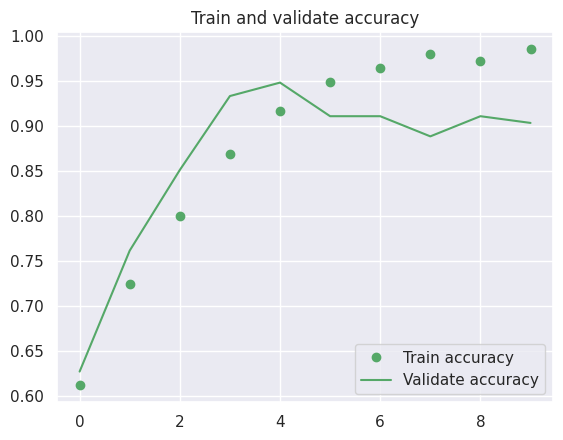

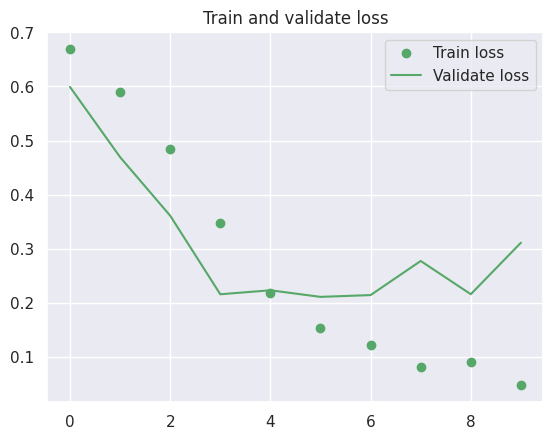

In [69]:
acc = history_cl.history['acc']
val_acc = history_cl.history['val_acc']
loss = history_cl.history['loss']
val_loss = history_cl.history['val_loss']
plt.plot( acc, 'go', label='Train accuracy')
plt.plot( val_acc, 'g', label='Validate accuracy')
plt.title('Train and validate accuracy')
plt.legend()

plt.figure()
plt.plot( loss, 'go', label='Train loss')
plt.plot( val_loss, 'g', label='Validate loss')
plt.title('Train and validate loss')
plt.legend()
plt.show()

In [70]:
# Load tokenizer object
with open('tokenizer.pickle', 'rb') as handle:
    tokenizers = pickle.load(handle)

model = load_model('/content/cnn+lastm-best_model.h5')

In [71]:
twt = ['I am done with my life! I just want to die.']
twt = tokenizer.texts_to_sequences(twt)
twt = pad_sequences(twt, maxlen=60, dtype='int32')

predicted = model.predict(twt,batch_size=1,verbose = True)
if(np.argmax(predicted) == 0):
    print("Potential Suicide Post")
elif (np.argmax(predicted) == 1):
    print("Non Suicide Post")

1/1 [==============================] - 1s 1s/step
Potential Suicide Post


## **Model Comparision**

In [72]:
results=pd.DataFrame({'Model':['LSTM-1 Layer','LSTM-2 Layer','GRU','CNN+LSTM'],
                     'Accuracy Score':[results_1[1],results_2[1],results_3[1],results_4[1]]})
result_df=results.sort_values(by='Accuracy Score', ascending=False)
result_df=result_df.set_index('Model')
result_df

,Accuracy Score
Model,
LSTM-2 Layer,0.932886
CNN+LSTM,0.932886
LSTM-1 Layer,0.928412
GRU,0.923937
